# 프로젝트: 인공지능과 가위바위보 하기

## 1. 나만의 데이터셋 만들기 

### 1.1. 데이터 모으기
* 참고 링크: https://teachablemachine.withgoogle.com/

~/aiffel    
--- /rock_scissor_paper    
------ /dataset    
------ /testN(N= 데이터개수)
---------/rock    
---------/scissor    
---------/paper    
------ /datasetN(N= 데이터개수)      
---------/rock    
---------/scissor    
---------/paper    
------ [E-01]RockPaperScissor.ipynb    
------ [E-01]DataSplit.ipynb    

In [1]:
pwd

'/home/aiffel/aiffel/rock_scissor_paper/code'

In [2]:
ls

 dataset/  '[E-01]DataSplit.ipynb'  '[E-01]RockPaperScissor.ipynb'


### 1.2. 데이터 정제하기
#### Resize and Normalization

In [3]:
# 사용 라이브러리 import

from PIL import Image
import os, glob, shutil
import numpy as np 
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras

#### Fix random seed
* 참고 블로그: https://hoya012.github.io/blog/reproducible_pytorch/    
* 참고 블로그: https://suneeta-mall.github.io/2019/12/22/Reproducible-ml-tensorflow.html

In [4]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SEED = 555
set_seeds(SEED)

#### Resize images
* 28 x 28로 이미지 크기를 조절 

In [5]:
def resize_img(class_name):
    # # 가위, 바위, 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
    image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_original" + class_name 
    print("이미지 디렉토리 경로: ", image_dir_path)

    images=glob.glob(image_dir_path + "/*.jpg")  

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")

    print(class_name + "이미지 resize 완료!")

In [6]:
# class_names = ['rock','scissor', 'paper']
# for class_name in class_names:
#     resize_img(class_name)

### 1.3. 데이터 불러오기
* Data Load from directory 
* 묵 : 0, 찌 : 1, 빠 : 2

In [7]:
def load_data(img_path, number_of_data):
    # (묵 : 0, 찌 : 1, 빠 : 2)
    img_size=28
    color=3
    #이미지 데이터와 라벨(묵 : 0, 찌 : 1, 빠 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # Rock : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # Scissor : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # Paper : 2
        idx=idx+1
    
#     print("데이터의 이미지 개수는",idx,"입니다.")
    
    return imgs, labels

#### Data Split

Data Split은 보통 코딩으로 해주지만 이번 시간에는 해당 부분까지의 진도는 안 나간 상태라 수작업해줬음.  
* Test에 배경이 다른 이미지를 3~4 종류 섞어서 구성해줌
    
#### Data Normalization

In [8]:
number_of_train = 14100 
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_100" # my dataset
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_200" # my dataset + different background
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_400rs" # increase Rock & Scissor data
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_700_rs_400_p" # increase all 
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_3300_rs_1200_p" # increase all 
# train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_4500" # increase all 
train_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/dataset_14100"
(x_train, y_train)=load_data(train_dir_path, number_of_train)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

number_of_test = 240 # 여러 데이터셋 합친 Test set 
# test_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/test1" # different data from Train set
# test_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/test2" # increase test data
test_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/dataset/test3" # 편향되거나 중복(연속 촬영 결과 너무 비슷한 data) 제거
(x_test, y_test)=load_data(test_dir_path, number_of_test)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (14100, 28, 28, 3)
y_train shape: (14100,)
x_test shape: (240, 28, 28, 3)
y_test shape: (240,)


#### Check Image dataset    
* 참고자료: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
* dataset을 구축할 때 유의할 점은 사람이 육안으로 구분하기 힘든 데이터셋은 컴퓨터도 힘들어한다는 점이다. 해당 사진처럼 사물이 있는 경우는 주로 28x28 보다는 더 큰 이미지로 한다. 이유는 JPEG, JPG와 같은 이미지 압축 형식은 말 그대로 압축하면서 계속 손실이 발생한다. Resize는 어느 정도 손실을 감수해야하다보니 이미지가 엄청 깨진다면 굳이 Resize하지 않아도 된다. 
* 특히 Convolution 연산을 거치면 갈수록 이미지 크기는 작아지기 때문에 경량화(?)를 위해 Resize한다고 무조건 좋은건 아니다. 

Text(0.5, 1.0, '2')

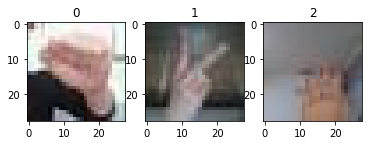

In [9]:
plt.subplot(1,3,1)
plt.imshow(x_train[0])
plt.title(y_train[0])

plt.subplot(1,3,2)
plt.imshow(x_train[6000])
plt.title(y_train[6000])

plt.subplot(1,3,3)
plt.imshow(x_train[10000])
plt.title(y_train[10000])


## 2. 모델 만들기 
### 2.1. 딥러닝 네트워크 설계하기

#### gpu 용량 효율적으로 사용하기 
* TF의 단점 중 하나가 GPU 용량을 다 잡아먹는 경우가 있는데 이를 방지하여 사용할 만큼만의 용량을 할당하는 코드이다. 

In [10]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Hyperparameter tuning
* 각 필터 수와 뉴런 수를 조절하여 네트워크를 구축한다. 
* 파라미터 수가 많다고 항상 좋은 것은 아니다. Overfitting 발생할 수 있다. 
* 논문이나 비슷한 피쳐(해당 경우엔 edge 중심인 MNIST 등)에 쓰였던 파라미터를 참고했다. 
* 참고 블로그:https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

In [27]:
n_channel_1=32
n_channel_2=32
n_dense=64
n_train_epoch=20 # 40까지 시도했을때 20에서 정확도가 0.98로 수렴함

#### 정규화(Regularizer)
* L2 정규화: https://keras.io/ko/regularizers/
* Dropout: Layer가 늘어나 네트워크가 깊어지지만 과한(?) 설정일 수 있다고 판단된다. 

In [28]:
model=keras.models.Sequential()

model.add(keras.layers.Conv2D(n_channel_1, (3,3), kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(n_dense, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수:', len(model.layers))

Model에 추가된 Layer 개수: 8


In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

### 2.2. 모델 학습하기 
* Dataset이 커질수록 epoch 수를 늘려가는 편이 좋다. 
* 연속 촬영된 데이터셋이다보니 일련의 연속된 이미지를 학습하기 보다 순서를 섞어주는 편이 학습에 더 좋다. 

In [30]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련 
history = model.fit(x_train, y_train, epochs = n_train_epoch, shuffle = True)

Epoch 1/20
441/441 [==============================] - 2s 4ms/step - loss: 1.4657 - accuracy: 0.5474
Epoch 2/20
441/441 [==============================] - 2s 4ms/step - loss: 0.6470 - accuracy: 0.7825
Epoch 3/20
441/441 [==============================] - 2s 5ms/step - loss: 0.4477 - accuracy: 0.8787
Epoch 4/20
441/441 [==============================] - 2s 4ms/step - loss: 0.3573 - accuracy: 0.9177
Epoch 5/20
441/441 [==============================] - 2s 4ms/step - loss: 0.3140 - accuracy: 0.9351
Epoch 6/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2790 - accuracy: 0.9494
Epoch 7/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2740 - accuracy: 0.9516
Epoch 8/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2550 - accuracy: 0.9603
Epoch 9/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2415 - accuracy: 0.9645
Epoch 10/20
441/441 [==============================] - 2s 4ms/step - loss: 0.2322 - accuracy: 0.9673

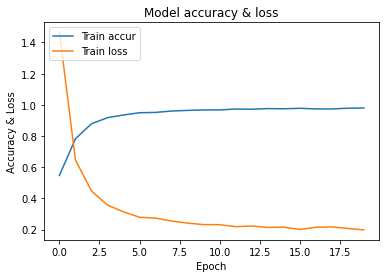

In [31]:
# 훈련 과정 시각화 (정확도와 손실)
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy & Loss')
plt.legend(['Train accur', 'Train loss'], loc='upper left')
plt.show()

## 3. 모델 확인하기
### 3.1. 모델 평가하기 
* Test set을 활용해 fit 함수로 학습된 model의 성능을 확인한다. 

In [32]:
# 모델 시험 
# verbose = 2일 경우 최종값만 보여줌 
# verbose = 1일 경우 progress bar, 0일 경우 아무것도 출력 안 함
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

8/8 - 0s - loss: 1.4956 - accuracy: 0.7333
test_loss: 1.4955825805664062 
test_accuracy: 0.7333333492279053


### 3.2. 예측 결과 확인하기 

In [26]:
predicted_result = model.predict(x_test)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [0.00143413 0.00877224 0.98979366]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


#### Wrong prediction 확인하기 
* 해당 결과를 통해 틀리게 답하는 사진의 특징을 확인하고 데이터셋을 수정하는데 반영할 수 있다. 
* plot하는 방식 외에도 histogram을 활용해서 각 label별로 틀린 답의 분포를 확인할 수 있다. 

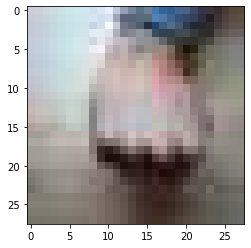

In [18]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

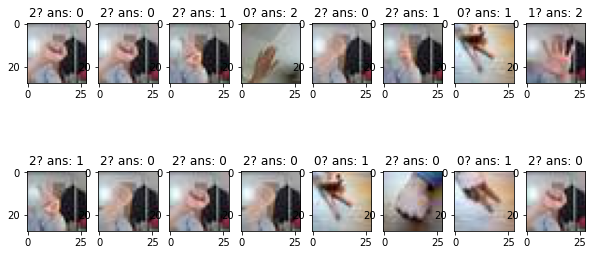

In [19]:
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 10개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=16)

sub_i = 1 
plt.figure(figsize=(10, 5))
for n in samples:
    plt.subplot(2,8,sub_i)
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.title(str(predicted_labels[n]) + "? ans: " + str(y_test[n]))
    # label = 0, 1, 2(묵, 찌, 빠)
    sub_i = sub_i + 1

## 4. 프로젝트 마치며 
* Debugging 기록노트: https://vg-rlo.tistory.com/22
        
* 블로그에는 다 쓰지 못한 시도들도 많았다. 이번 노드는 첫 시작인 만큼 가볍게 여러 방식을 시도해보는 것에 의미를 두었다. 정확도가 생각보다 안나와준 것은 너무 아쉽지만 그래도 다음 프로젝트가 기다리고 있으니.. 현재까지 노드 안에서 배운 내용만 반영하려고 노력했다. 이전에 알고 있는 거까지 넣다보면 차근차근 배워가는 의미가 없을거 같아 정규화(L2, Dropout)와 데이터셋을 정제하는 정도만 시도해보았다. 
         
* 시도했던 방법들    
1) 데이터셋 정제: 특징이 튀는 클래스만 정답으로 도출하는 경향을 다른 데이터셋을 늘려주는 식으로 해결했다. Test와 Train set이 겹치지 않는 선에서 배경을 다양하게 함으로써 랜덤성을 보장해주도록 했다.    
2) 정규화: epoch을 늘리거나 파라미터가 바뀌거나 데이터셋이 변경될 때 한번씩 요동치는 Loss, Accuracy 그래프를 확인했다. 그래서 L2 regularization과 Dropout을 추가하여 Overfitting을 예방했다.     
3) 하이퍼 파라미터 튜닝: epoch, channel 수, 뉴런 수 등과 같은 요소를 조절해가면서 해당 데이터셋에서 가장 좋은 결과를 내는 파라미터를 찾았다.     